# Import and I/O

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn

# set option so that e.g. df.head() will show all columns and none are omitted 
pd.set_option('display.max_columns', None)

import os
print("Current working directory: ", os.getcwd())

# Specify the year
year = "2010-2015"  # Change this to the desired year

# Define file paths based on the year
csv_file_path = f"..\\Data\\EU\\EU {year}.csv"
parquet_file_path = f"..\\Data\\EU\\EU {year}_dtypes.parquet"
parquet_nanplaceholder_path = f"..\\Data\\EU\\EU {year}_dtypes_nanplaceholder.parquet"
parquet_dupecounts_reduced_path = f"..\\Data\\EU\\EU {year}_dtypes_nanplaceholder_dupecounts_reduced.parquet"

Current working directory:  c:\Users\onepl\Desktop\Finanzen Behörden etc - Copy\Bewerbung\Fortbildungen\DS Bootcamp\Project Co2 git\aug24_bds_int---co2\notebooks\Andreas


In [2]:
# as a prerequisit before merging (concatenating) the DFs, check if all rows are labeled with the correct year

for year in ["2010-2015"] + [str(x) for x in range(2016,2024)]:
    parquet_dupecounts_reduced_path = f"..\\Data\\EU\\EU {year}_dtypes_nanplaceholder_dupecounts_reduced.parquet"
    df = pd.read_parquet(parquet_dupecounts_reduced_path)
    years_in_year = df["year"].value_counts()
    print(f"In the dataset for {year} these are the values of the \"year\" column: \n{years_in_year}")
    rows_labeled_with_a_year = df["year"].value_counts().sum()
    print(f"There are {len(df)} rows in the dataset altogether and {rows_labeled_with_a_year} entries for \"year\".\n")
    
    

In the dataset for 2010-2015 these are the values of the "year" column: 
2015    431559
2014    398047
2013    380634
2011    310767
2012    307442
2010    272279
Name: year, dtype: Int64
There are 2100728 rows in the dataset altogether and 2100728 entries for "year".

In the dataset for 2016 these are the values of the "year" column: 
2016    444106
Name: year, dtype: Int64
There are 444106 rows in the dataset altogether and 444106 entries for "year".

In the dataset for 2017 these are the values of the "year" column: 
2017    424145
Name: year, dtype: Int64
There are 424145 rows in the dataset altogether and 424145 entries for "year".

In the dataset for 2018 these are the values of the "year" column: 
2018    1240905
Name: year, dtype: Int64
There are 1240905 rows in the dataset altogether and 1240905 entries for "year".

In the dataset for 2019 these are the values of the "year" column: 
2019    2588053
Name: year, dtype: Int64
There are 2588053 rows in the dataset altogether and 2

# Merge all years

In [3]:
# Join all years vertically

EU_dfs = []

for year in ["2010-2015"] + [str(x) for x in range(2016, 2024)]:
    parquet_dupecounts_reduced_path = f"..\\Data\\EU\\EU {year}_dtypes_nanplaceholder_dupecounts_reduced.parquet"
    df = pd.read_parquet(parquet_dupecounts_reduced_path)
    EU_dfs.append(df)

EU_df = pd.concat(EU_dfs, axis = 0, ignore_index=True)

In [1]:
# Display number of rows per year in merged df (can visually compare to above counts before merge)
EU_df["year"].value_counts().sort_index()

NameError: name 'EU_df' is not defined


## save

In [5]:
# Save merged Dataframe
EU_df.to_parquet("..\Data\EU\EU all.parquet")

In [ ]:
# load dataset
df = pd.read_parquet("..\Data\EU\EU all.parquet")

# Optimize dtypes

In [8]:
# Optimize memory usage by checking if after the merge any column (dataype) can still be optimized/reduced

def optimize_dtypes(df):
    # Calculate total memory usage before optimization
    before_mem = df.memory_usage(deep=True).sum()
    print(f"Total memory usage before optimization: {before_mem / 1024**2:.2f} MB")
    
    # Convert all object type to category
    obj_cols = df.select_dtypes(include="object").columns
    df[obj_cols] = df[obj_cols].astype("category")
    
    # Downcast integer columns in place
    int_cols = df.select_dtypes(include='int').columns
    df[int_cols] = df[int_cols].apply(pd.to_numeric, downcast='integer')
    
    # Downcast float columns in place
    float_cols = df.select_dtypes(include='float').columns
    df[float_cols] = df[float_cols].apply(pd.to_numeric, downcast='float')
    
    # Calculate total memory usage after optimization
    after_mem = df.memory_usage(deep=True).sum()
    print(f"Total memory usage after optimization: {after_mem / 1024**2:.2f} MB")
    
optimize_dtypes(EU_df)

Total memory usage before optimization: 18702.28 MB
Total memory usage after optimization: 1616.06 MB


In [9]:
EU_df.info()  

# shows that aside from object type being converted to category only #identical occurences was reduced from int64 to int16


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14442792 entries, 0 to 14442791
Data columns (total 41 columns):
 #   Column                 Dtype   
---  ------                 -----   
 0   ID                     Int32   
 1   Country                category
 2   VFN                    category
 3   Mp                     category
 4   Mh                     category
 5   Man                    category
 6   MMS                    category
 7   Tan                    category
 8   T                      category
 9   Va                     category
 10  Ve                     category
 11  Mk                     category
 12  Cn                     category
 13  Ct                     category
 14  Cr                     category
 15  r                      Int32   
 16  m (kg)                 Int16   
 17  Mt                     Int16   
 18  Enedc (g/km)           Int16   
 19  Ewltp (g/km)           Int16   
 20  W (mm)                 Int16   
 21  At1 (mm)               Int16 

## save/read

In [10]:
# Save again
EU_df.to_parquet("..\Data\EU\EU all_dtypes.parquet")

In [26]:
df = pd.read_parquet("..\..\data\EU\EU all_dtypes.parquet")

# Clean Tan

In [27]:
EU_df = df

In [28]:
# In column "Tan" (Type Approval number) fix inconsistent naming (capital "E" vs small "e")

# 1. Check how many of each

count_e = EU_df.Tan.apply(lambda x: x.startswith("e")).sum()
count_E = EU_df.Tan.apply(lambda x: x.startswith("E")).sum()

print(f"{count_e} times e, {count_E} times E, sum = {count_E+count_e}. #values in df: {len(EU_df)}")

8505255 times e, 5436932 times E, sum = 13942187. #values in df: 14442792


In [29]:
# 2. Change to consistent small "e"

EU_df["Tan"] = EU_df.Tan.apply(lambda x: "e" + x[1:] if x.startswith("E") else x).astype("category")

In [30]:
# 3. Check if conversion successful

count_e = EU_df.Tan.apply(lambda x: x.startswith("e")).sum()
count_E = EU_df.Tan.apply(lambda x: x.startswith("E")).sum()

print(f"{count_e} times e, {count_E} times E, sum = {count_E+count_e}. #values in df: {len(EU_df)}")

13942187 times e, 0 times E, sum = 13942187. #values in df: 14442792


In [31]:
df.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14442792 entries, 0 to 14442791
Data columns (total 41 columns):
 #   Column                 Non-Null Count     Dtype   
---  ------                 --------------     -----   
 0   ID                     14442792 non-null  Int32   
 1   Country                14442792 non-null  category
 2   VFN                    14442792 non-null  category
 3   Mp                     14442792 non-null  category
 4   Mh                     14442792 non-null  category
 5   Man                    14442792 non-null  category
 6   MMS                    14442792 non-null  category
 7   Tan                    14442792 non-null  category
 8   T                      14442792 non-null  category
 9   Va                     14442792 non-null  category
 10  Ve                     14442792 non-null  category
 11  Mk                     14442792 non-null  category
 12  Cn                     14442792 non-null  category
 13  Ct                     14442792 non-null

In [37]:
# Group by 'ID' and 'year' and count occurrences
duplicate_counts = df.groupby(['ID', 'year']).size().reset_index(name='count')

# Filter rows where count is greater than 1 (indicating duplicates)
duplicate_rows = duplicate_counts[duplicate_counts['count'] > 1]

# Display the duplicate rows
print(duplicate_rows)


Empty DataFrame
Columns: [ID, year, count]
Index: []


In [43]:
# Save again
EU_df.to_parquet("..\Data\EU\EU all_dtypes_Tan.parquet")

# Treat NaN

## check missing/NAN

In [33]:
# Now Check if missing values are consistently marked

# For that purpose print number of pd.NA, np.nan, -99, "-99"

df = EU_df

# Initialize a list to store the counts
counts_list = []

for col in df.columns:
    data = df[col]
    
    # Initialize counts
    nan_count = 0
    pd_na_count = 0
    minus_99_count = 0
    str_minus_99_count = 0

    # Total missing values (np.nan and pd.NA)
    total_missing = data.isna().sum()

    # For numeric columns (floats and integers)
    if pd.api.types.is_numeric_dtype(data):
        # Missing values are represented as np.nan
        nan_count = total_missing
        
        # Count occurrences of -99
        minus_99_count = (data == -99).sum()
    
    # For categorical columns
    elif pd.api.types.is_categorical_dtype(data):
        # Missing values are represented as pd.NA
        pd_na_count = total_missing
        
        # Count occurrences of "-99" as a string
        str_minus_99_count = (data == "-99").sum()
    
    # For object (string) columns
    elif pd.api.types.is_object_dtype(data):
        # Missing values can be np.nan, pd.NA, or None
        total_missing = data.isna().sum()
        
        # Attempt to differentiate between np.nan and pd.NA
        # Convert data to a NumPy array for element-wise comparison
        values = data.to_numpy()

        # Create masks for np.nan and pd.NA
        nan_mask = pd.isna(values) & (values != pd.NA)
        pd_na_mask = pd.isna(values) & (values == pd.NA)

        nan_count = nan_mask.sum()
        pd_na_count = pd_na_mask.sum()
        
        # Count occurrences of -99 (as numeric) and "-99" (as string)
        minus_99_count = (data == -99).sum()
        str_minus_99_count = (data == "-99").sum()
    
    else:
        # For other data types, count total missing as np.nan
        nan_count = total_missing
    
    # Append the counts to the list
    counts_list.append({
        'Column': col,
        'np.nan': nan_count,
        'pd.NA': pd_na_count,
        '-99': minus_99_count,
        '"-99"': str_minus_99_count
    })

# Convert the list to a DataFrame
counts_df = pd.DataFrame(counts_list)

# Display the counts DataFrame
print(counts_df)


                   Column  np.nan  pd.NA       -99     "-99"
0                      ID       0      0         0         0
1                 Country       0      0         0         0
2                     VFN       0      0         0   6022343
3                      Mp       0      0         0   1538457
4                      Mh       0      0         0         0
5                     Man       0      0         0    310768
6                     MMS       0      0         0   6048284
7                     Tan       0      0         0    490543
8                       T       0      0         0     62037
9                      Va       0      0         0    100484
10                     Ve       0      0         0    225223
11                     Mk       0      0         0     42908
12                     Cn       0      0         0     49370
13                     Ct       0      0         0     24689
14                     Cr       0      0         0   2811048
15                      

## convert missing and dtypes

In [ ]:
# Convert all missing values (-99, "-99") to np.nan for numerical values and pd.NA for categorical, respectively
# Also make all numerical cols float32 (can handle np.nan).
# This increases memory usage slightly but gives better consistency and compatibility with numpy, pandas and other libraries

df = EU_df

# Calculate total memory usage before optimization
before_mem = df.memory_usage(deep=True).sum()
print(f"Total memory usage before optimization: {before_mem / 1024**2:.2f} MB")

# Identify all numerical columns (both integer and float)
num_cols = df.select_dtypes(include=['number']).columns.tolist()
num_cols = [col for col in num_cols if col not in ['ID', 'year']]
print(f"Numerical columns to be converted: {num_cols}")

# Replace -99 with np.nan and convert numerical columns to float32
for col in num_cols:
    # Replace -99 with np.nan if necessary
    df[col] = df[col].replace(-99, np.nan)
    # Convert to float32
    df[col] = df[col].astype('float32')
    print(f"Column '{col}' converted to float32.")
    
# For 'ID' and 'year', handle missing values appropriately and convert to Int64 data type
for col in ['ID', 'year']:
    df[col] = df[col].replace(-99, np.nan)
    # To handle NaN in integer columns, convert to pandas nullable integer type
    df[col] = df[col].astype('Int64')
    print(f"Column '{col}' processed for missing values with Int64 dtype.")

# Replace -99 in category columns
cat_cols = df.select_dtypes(include=['category']).columns.tolist()
print(f"Category columns: {cat_cols}")

for col in cat_cols:
    # Convert to object, replace -99 with pd.NA, and convert back to category
    df[col] = df[col].astype('object')
     # Replace '-99' (string) with np.nan
    df[col] = df[col].replace('-99', np.nan)
    # Replace -99 (integer) with np.nan
    df[col] = df[col].replace(-99, np.nan)
    # Convert back to category
    df[col] = df[col].astype('category')
    print(f"Column '{col}' processed for missing values.")

# Replace -99 in object columns
obj_cols = df.select_dtypes(include=['object']).columns.tolist()
print(f"Object columns: {obj_cols}")

for col in obj_cols:
    # Replace '-99' (string) with np.nan
    df[col] = df[col].replace('-99', np.nan)
    # Replace -99 (integer) with np.nan
    df[col] = df[col].replace(-99, np.nan)
    print(f"Column '{col}' processed for missing values.")

# Verify data types and memory usage
print("\nData types after conversion:")
print(df.dtypes)

# Calculate total memory usage after optimization
after_mem = df.memory_usage(deep=True).sum()
print(f"\nTotal memory usage after optimization: {after_mem / 1024**2:.2f} MB")

# Print the memory usage difference
memory_difference = after_mem - before_mem
print(f"Memory usage difference: {memory_difference / 1024**2:.2f} MB")


Total memory usage before optimization: 1613.99 MB
Numerical columns to be converted: ['r', 'm (kg)', 'Mt', 'Enedc (g/km)', 'Ewltp (g/km)', 'W (mm)', 'At1 (mm)', 'At2 (mm)', 'ec (cm3)', 'ep (KW)', 'z (Wh/km)', 'Ernedc (g/km)', 'Erwltp (g/km)', 'De', 'Vf', 'Fuel consumption ', 'Electric range (km)', '#identical occurences']
Column 'r' converted to float32.
Column 'm (kg)' converted to float32.
Column 'Mt' converted to float32.
Column 'Enedc (g/km)' converted to float32.
Column 'Ewltp (g/km)' converted to float32.
Column 'W (mm)' converted to float32.
Column 'At1 (mm)' converted to float32.
Column 'At2 (mm)' converted to float32.
Column 'ec (cm3)' converted to float32.
Column 'ep (KW)' converted to float32.
Column 'z (Wh/km)' converted to float32.
Column 'Ernedc (g/km)' converted to float32.
Column 'Erwltp (g/km)' converted to float32.
Column 'De' converted to float32.
Column 'Vf' converted to float32.
Column 'Fuel consumption ' converted to float32.
Column 'Electric range (km)' converte

## save/read

In [39]:
# Save again

EU_df.to_parquet("..\..\data\EU\EU all_dtypes_Tan_NaN_float32_Int64.parquet")


In [2]:
EU_df = pd.read_parquet("..\..\data\EU\EU all_dtypes_Tan_NaN_float32_Int64.parquet")

## None, NaN, NA sandbox

## f: identify_nan_value

In [12]:
import numpy as np
import pandas as pd
import math

def identify_nan_value(value):
    # Check if it's a string that looks like "nan" or "None"
    if isinstance(value, str):
        if value == 'nan':
            return "It's a string 'nan'"
        elif value == 'None':
            return "It's a string 'None'"
        else:
            return f"It's a regular string: {value}"
    
    # Check for pd.NA (specific pandas type)
    elif type(value) == pd._libs.missing.NAType:
        return "It's pd.NA"
    
    # Check for None (Python's NoneType)
    elif value is None:
        return "It's None"
    
    # Check for np.nan or float('nan')
    elif isinstance(value, float) and math.isnan(value):
        return "It's np.nan"
    
    else:
        return f"It's another value: {value}"

# Example usage
value = df.MMS.iloc[2]
result = identify_nan_value(value)
print(result)


It's np.nan


In [14]:
print(df.MMS.iloc[2])

nan


In [10]:
type(df.MMS.iloc[2])


float

In [16]:
df.VFN.head()

0    NaN
1    NaN
2    NaN
3    NaN
4    NaN
Name: VFN, dtype: category
Categories (29048, object): [' IP-02-VF7-2018-7220 ', ' IP-24-WBA-2017-4112', ' IP-24-WBA-2017-4139', ' IP-24-WBA-2017-4142', ..., 'ÎP202_2411-W1K-1', 'Î™P-e3-1C4-2018-0013', 'Î™P-e3-1C4-2018-0015', 'ÏP-C519_2019_00007-WF0-1']

In [21]:
print(df.VFN.iloc[0], type(df.VFN.iloc[0]))

nan <class 'float'>


In [22]:
df.VFN.iloc[0] = pd.NA

In [23]:
print(df.VFN.iloc[0], type(df.VFN.iloc[0]))

nan <class 'float'>


In [60]:
identify_nan_value(df.VFN.iloc[0])

"It's np.nan"

In [48]:
df2 = pd.DataFrame({'num': [1,2,3,4],
                    'string': ['A','B','C','D'],
                    'cat': ['Eins','Zwei', 'Zwei', 'Zwei']})

In [33]:
df2

,num,string,cat
0,1,A,Eins
1,2,B,Zwei
2,3,C,Zwei
3,4,D,Zwei


In [49]:
for col in df2.columns:
    df2.loc[0, col] = None
    df2.loc[1, col] = np.nan
    df2.loc[2, col] = pd.NA

In [54]:
for col in range(3):
    df2.iloc[0, col] = None
    df2.iloc[1, col] = np.nan
    df2.iloc[2, col] = pd.NA

In [55]:
print(df2.head())

   num string   cat
0  NaN   None  None
1  NaN    NaN   NaN
2  NaN   <NA>  <NA>
3  4.0      D  Zwei


In [59]:
for col in df2:
    for i in df2[col]:
        print(i, identify_nan_value(i))

nan It's np.nan
nan It's np.nan
nan It's np.nan
4.0 It's another value: 4.0
None It's None
nan It's np.nan
<NA> It's pd.NA
D It's a regular string: D
None It's None
nan It's np.nan
<NA> It's pd.NA
Zwei It's a regular string: Zwei


## check if NaN conversion successfull

In [3]:
# Check if conversion successfull
# Therefore again print number of pd.NA, np.nan, -99, "-99" (maybe better clean up the code and make a proper fuction out of that (and others))

df = EU_df

# Initialize a list to store the counts
counts_list = []

for col in df.columns:
    data = df[col]
    
    # Initialize counts
    nan_count = 0
    pd_na_count = 0
    minus_99_count = 0
    str_minus_99_count = 0

    # Total missing values (np.nan and pd.NA)
    total_missing = data.isna().sum()

    # For numeric columns (floats and integers)
    if pd.api.types.is_numeric_dtype(data):
        # Missing values are represented as np.nan
        nan_count = total_missing
        
        # Count occurrences of -99
        minus_99_count = (data == -99).sum()
    
    # For categorical columns
    elif pd.api.types.is_categorical_dtype(data):
        # Missing values are represented as pd.NA
        pd_na_count = total_missing
        
        # Count occurrences of "-99" as a string
        str_minus_99_count = (data == "-99").sum()
    
    # For object (string) columns
    elif pd.api.types.is_object_dtype(data):
        # Missing values can be np.nan, pd.NA, or None
        total_missing = data.isna().sum()
        
        # Attempt to differentiate between np.nan and pd.NA
        # Convert data to a NumPy array for element-wise comparison
        values = data.to_numpy()

        # Create masks for np.nan and pd.NA
        nan_mask = pd.isna(values) & (values != pd.NA)
        pd_na_mask = pd.isna(values) & (values == pd.NA)

        nan_count = nan_mask.sum()
        pd_na_count = pd_na_mask.sum()
        
        # Count occurrences of -99 (as numeric) and "-99" (as string)
        minus_99_count = (data == -99).sum()
        str_minus_99_count = (data == "-99").sum()
    
    else:
        # For other data types, count total missing as np.nan
        nan_count = total_missing
    
    # Append the counts to the list
    counts_list.append({
        'Column': col,
        'np.nan': nan_count,
        'pd.NA': pd_na_count,
        '-99': minus_99_count,
        '"-99"': str_minus_99_count
    })

# Convert the list to a DataFrame
counts_df = pd.DataFrame(counts_list)

# Display the counts DataFrame
print(counts_df)


                   Column    np.nan     pd.NA  -99  "-99"
0                      ID         0         0    0      0
1                 Country         0         0    0      0
2                     VFN         0   6022343    0      0
3                      Mp         0   1538457    0      0
4                      Mh         0         0    0      0
5                     Man         0    310768    0      0
6                     MMS         0   6048284    0      0
7                     Tan         0    490543    0      0
8                       T         0     62037    0      0
9                      Va         0    100484    0      0
10                     Ve         0    225223    0      0
11                     Mk         0     42908    0      0
12                     Cn         0     49370    0      0
13                     Ct         0     24689    0      0
14                     Cr         0   2811048    0      0
15                      r         4         0    0      0
16            

In [36]:
EU_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14442792 entries, 0 to 14442791
Data columns (total 41 columns):
 #   Column                 Dtype   
---  ------                 -----   
 0   ID                     Int64   
 1   Country                category
 2   VFN                    category
 3   Mp                     category
 4   Mh                     category
 5   Man                    category
 6   MMS                    category
 7   Tan                    category
 8   T                      category
 9   Va                     category
 10  Ve                     category
 11  Mk                     category
 12  Cn                     category
 13  Ct                     category
 14  Cr                     category
 15  r                      float32 
 16  m (kg)                 float32 
 17  Mt                     float32 
 18  Enedc (g/km)           float32 
 19  Ewltp (g/km)           float32 
 20  W (mm)                 float32 
 21  At1 (mm)               float3

# Histplot Ewltp

<Axes: xlabel='Ewltp (g/km)', ylabel='Count'>

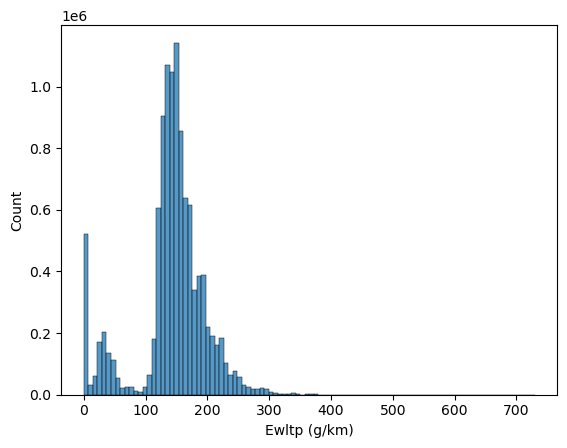

In [19]:
# Quick histplot of likely target variable
sn.histplot(x = "Ewltp (g/km)", data = EU_df, bins = 100)

# dupe removal possibilites

In [20]:
# Check how many additional dupes can be removed after the merge
drop_cols=['Date of registration', 'ID', "year", "#identical occurences"]
group_cols = [col for col in df.columns if col not in drop_cols]

EU_df.duplicated(subset = group_cols).sum()

53719

In [21]:
# Check how many dupes if we include identicals between countries
drop_cols=['Date of registration', 'ID', "year", "#identical occurences", "Country"]
group_cols = [col for col in df.columns if col not in drop_cols]

EU_df.duplicated(subset = group_cols).sum()

208441

In [22]:
EU_df.columns

Index(['ID', 'Country', 'VFN', 'Mp', 'Mh', 'Man', 'MMS', 'Tan', 'T', 'Va',
       'Ve', 'Mk', 'Cn', 'Ct', 'Cr', 'r', 'm (kg)', 'Mt', 'Enedc (g/km)',
       'Ewltp (g/km)', 'W (mm)', 'At1 (mm)', 'At2 (mm)', 'Ft', 'Fm',
       'ec (cm3)', 'ep (KW)', 'z (Wh/km)', 'IT', 'Ernedc (g/km)',
       'Erwltp (g/km)', 'De', 'Vf', 'Status', 'year', 'Date of registration',
       'Fuel consumption ', 'ech', 'RLFI', 'Electric range (km)',
       '#identical occurences'],
      dtype='object')

In [23]:
# ignore most of the categorical cols about manufacurer, type etc. and see how many dupes would result
drop_cols=['Date of registration', 'ID', "year", "#identical occurences", "Country", 'VFN', 'Mp', 'Mh', 'Man', 'MMS', 'Tan', 'T', 'Va',
       'Ve', 'Mk', 'Cn', 'Ct', 'Cr', 'r']
group_cols = [col for col in df.columns if col not in drop_cols]

EU_df.duplicated(subset = group_cols).sum()

5648196